# Metrics sensitivity to alternative climate settings

The purpose of this notebook is to assess the sensitivity of the metrics values to various climate parameters.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Climate functions
from aerometrics.utils.functions import emission_profile_function
from aerometrics.metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from aerometrics.climate_models.co2_ipcc_climate_model import CO2_IPCC_ClimateModel
from aerometrics.climate_models.gwpstar_climate_model import GWPStarClimateModel
from aerometrics.climate_models.lwe_climate_model import LWEClimateModel
from aerometrics.climate_models.fair_climate_model import FairClimateModel

## Model parameters

In [2]:
# Simulation parameters
start_year = 1765  # start of simulation
t0 = 2020  # start of emission
time_horizon = 100  # time horizon for metric calculation
end_year = t0 + time_horizon  # end of simulation

# Climate model selection and parameters
climate_model = "FaIR"
model_settings = {"rcp": 'RCP45'}

## CO2 absolute metrics

In [3]:
# --- Absolute metrics for CO2 ---
species = "CO2"

# Emission profile
profile = "pulse"
unit_value = 1*10**10  # [kg]
emission_profile = emission_profile_function(start_year, t0, time_horizon, profile, unit_value)

# Species parameters
species_settings = {
    #"sensitivity_rf": 9.2e-16, # Not used with FaIR
    "ratio_erf_rf": 1.0,
}

# Run model
results_co2 = FairClimateModel(start_year, end_year, species, emission_profile, species_settings, model_settings).run()
radiative_forcing_co2_unit = results_co2["radiative_forcing"] / unit_value
effective_radiative_forcing_co2_unit = results_co2["effective_radiative_forcing"] / unit_value
temperature_co2_unit = results_co2["temperature"] / unit_value

# Calculate absolute metrics for pulse of CO2
agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(
    radiative_forcing_co2_unit, 
    effective_radiative_forcing_co2_unit, 
    1.0, 
    temperature_co2_unit, 
    time_horizon
)

## Species metrics

In [4]:
# --- Simulation for selected emission profile and species ---
species = "Contrails"
unit_value = 1*10**10  # [km]
emission_profile = emission_profile_function(start_year, t0, time_horizon, profile, unit_value)

# Initialise arrays for results
gwp_rf = np.zeros(3)
gwp_erf = np.zeros(3)
egwp_erf = np.zeros(3)
gtp = np.zeros(3)
ratr = np.zeros(3)

# Run simulation with different sets of species parameters
for k in range(0,3):
    if k == 0:
        sensitivity_rf = 2.23e-12
        ratio_erf_rf = 0.42
        efficacy_erf = 1.0
    elif k == 1:
        sensitivity_rf = 2.23e-12
        ratio_erf_rf = 0.55
        efficacy_erf = 0.38
    elif k == 2:
        sensitivity_rf = 2.23e-12 * 0.557
        ratio_erf_rf = 0.42
        efficacy_erf = 1.0

    species_settings = {
        "sensitivity_rf": sensitivity_rf, 
        "ratio_erf_rf": ratio_erf_rf, 
        "efficacy_erf": efficacy_erf
    }

    results = FairClimateModel(start_year, end_year, species, emission_profile, species_settings, model_settings).run()
    radiative_forcing_unit = results["radiative_forcing"] / unit_value
    effective_radiative_forcing_unit = results["effective_radiative_forcing"] / unit_value
    temperature_unit = results["temperature"] / unit_value

    # Calculate absolute metrics
    agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(
        radiative_forcing_unit, 
        effective_radiative_forcing_unit, 
        efficacy_erf, 
        temperature_unit, 
        time_horizon
    )

    # Calculate metrics relative to CO2 and store results
    gwp_rf[k], gwp_erf[k], egwp_rf, egwp_erf[k], gtp[k], igtp, ratr[k] = relative_metrics(
        agwp_rf_co2, 
        agwp_erf_co2, 
        aegwp_rf_co2, 
        aegwp_erf_co2, 
        agtp_co2, 
        iagtp_co2, 
        atr_co2, 
        agwp_rf, 
        agwp_erf, 
        aegwp_rf, 
        aegwp_erf, 
        agtp, 
        iagtp, 
        atr
    )

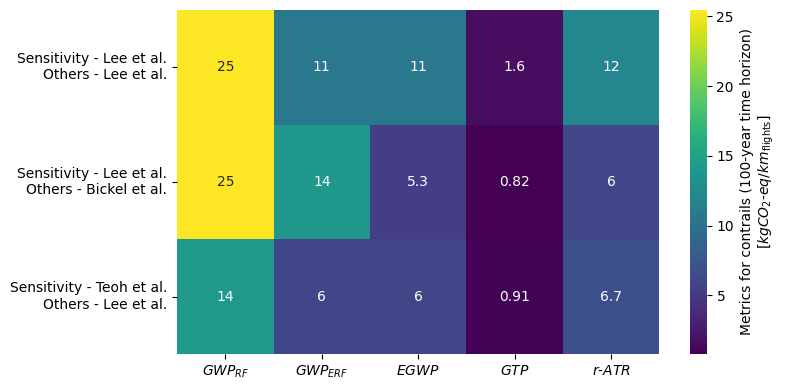

In [5]:
# Plot heatmap
selected_metrics = [r"$GWP_{RF}$", r"$GWP_{ERF}$", r"$EGWP$", r"$GTP$", r"$r\text{-}ATR$"]
data = np.zeros((3, 5))
data[:,0] = gwp_rf
data[:,1] = gwp_erf
data[:,2] = egwp_erf
data[:,3] = gtp
data[:,4] = ratr

plt.figure(figsize=(8, 4))
sns.heatmap(data, annot=True, cmap="viridis", cbar=True, xticklabels=selected_metrics,
            yticklabels=['Sensitivity - Lee et al.\nOthers - Lee et al.', 'Sensitivity - Lee et al.\nOthers - Bickel et al.', 'Sensitivity - Teoh et al.\nOthers - Lee et al.'], 
            cbar_kws={r"label": 'Metrics for contrails (100-year time horizon)\n[$kgCO_2\\text{-}eq/km_{\\text{flights}}$]'})
plt.tight_layout()
plt.savefig("figures/alternative_settings.pdf")
plt.show()